In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.random.set_seed(
    42
)


import seaborn as sns

tf_chkpt_path = 'tf_AlexNet_checkpoints/'

In [3]:
from src.helperFunctions import display_model_trainTestGraphs

# Training Set

In [4]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=225,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [5]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [6]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=8,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

In [7]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 5,
                           restore_best_weights=True,
                           mode='min')

# Model - AlexNet

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

200/200 [==============================] - 38s 192ms/step - loss: 0.0227 - accuracy: 0.9934 - precision: 0.9935 - recall: 0.9933 - val_loss: 1.9342 - val_accuracy: 0.7806 - val_precision: 0.7827 - val_recall: 0.7797
Epoch 24/60
200/200 [==============================] - 39s 193ms/step - loss: 0.0250 - accuracy: 0.9925 - precision: 0.9928 - recall: 0.9923 - val_loss: 1.3737 - val_accuracy: 0.8506 - val_precision: 0.8518 - val_recall: 0.8497
Epoch 25/60
200/200 [==============================] - 39s 193ms/step - loss: 0.0310 - accuracy: 0.9907 - precision: 0.9910 - recall: 0.9903 - val_loss: 1.4100 - val_accuracy: 0.7320 - val_precision: 0.7399 - val_recall: 0.7250
Epoch 26/60
200/200 [==============================] - 39s 193ms/step - loss: 0.0277 - accuracy: 0.9915 - precision: 0.9918 - recall: 0.9913 - val_loss: 1.1364 - val_accuracy: 0.8617 - val_precision: 0.8624 - val_recall: 0.8616
Epoch 27/60
200/200 [==============================] - 39s 192ms/step - loss: 0.0220 - accuracy: 0.9

Epoch 59/60
200/200 [==============================] - 39s 192ms/step - loss: 0.0036 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - val_loss: 1.2535 - val_accuracy: 0.8634 - val_precision: 0.8640 - val_recall: 0.8629
Epoch 60/60
200/200 [==============================] - 39s 193ms/step - loss: 0.0111 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 1.3333 - val_accuracy: 0.8451 - val_precision: 0.8456 - val_recall: 0.8445


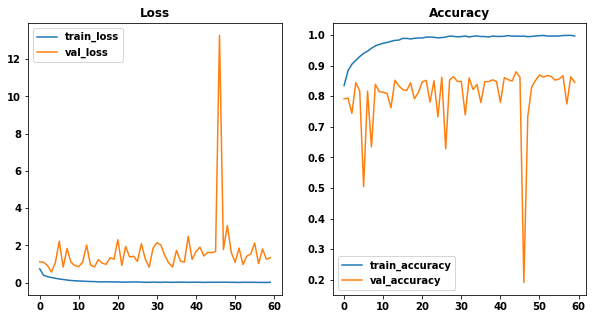

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(filters=96, kernel_size=11, strides=(4, 4), padding='valid', activation='relu',
                        input_shape=(227, 227, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),padding='valid'))

model.add(layers.Conv2D(filters=256, kernel_size=(
        5, 5), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(layers.Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=256, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"))
# model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
              loss= losses.CategoricalCrossentropy(),
              metrics = ['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=60,  # Number of epochs
                    validation_data=val_generator,
                    validation_freq=1,
                    validation_steps=200,  # Number of validation samples to run validation on
                    )

display_model_trainTestGraphs(results)

In [9]:
results.model.save(tf_chkpt_path+'Model_1')

INFO:tensorflow:Assets written to: tf_AlexNet_checkpoints/Model_1\assets


INFO:tensorflow:Assets written to: tf_AlexNet_checkpoints/Model_1\assets


# Model - AlexNet with one extra MaxPooling

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization_4 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_5 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

Epoch 22/60
200/200 [==============================] - 33s 166ms/step - loss: 0.0378 - accuracy: 0.9879 - precision_1: 0.9881 - recall_1: 0.9876 - val_loss: 0.8042 - val_accuracy: 0.8653 - val_precision_1: 0.8678 - val_recall_1: 0.8638
Epoch 23/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0308 - accuracy: 0.9903 - precision_1: 0.9906 - recall_1: 0.9901 - val_loss: 1.8208 - val_accuracy: 0.6809 - val_precision_1: 0.6876 - val_recall_1: 0.6673
Epoch 24/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0313 - accuracy: 0.9902 - precision_1: 0.9904 - recall_1: 0.9899 - val_loss: 0.9425 - val_accuracy: 0.8238 - val_precision_1: 0.8265 - val_recall_1: 0.8219
Epoch 25/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0228 - accuracy: 0.9924 - precision_1: 0.9925 - recall_1: 0.9923 - val_loss: 1.0318 - val_accuracy: 0.8695 - val_precision_1: 0.8698 - val_recall_1: 0.8688
Epoch 26/60
200/200 [==============================] - 3

Epoch 57/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0107 - accuracy: 0.9969 - precision_1: 0.9969 - recall_1: 0.9968 - val_loss: 1.1700 - val_accuracy: 0.8773 - val_precision_1: 0.8779 - val_recall_1: 0.8772
Epoch 58/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0130 - accuracy: 0.9963 - precision_1: 0.9963 - recall_1: 0.9962 - val_loss: 1.1563 - val_accuracy: 0.8622 - val_precision_1: 0.8633 - val_recall_1: 0.8618
Epoch 59/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0101 - accuracy: 0.9971 - precision_1: 0.9971 - recall_1: 0.9970 - val_loss: 4.1284 - val_accuracy: 0.6879 - val_precision_1: 0.6889 - val_recall_1: 0.6864
Epoch 60/60
200/200 [==============================] - 33s 165ms/step - loss: 0.0063 - accuracy: 0.9981 - precision_1: 0.9981 - recall_1: 0.9981 - val_loss: 1.2174 - val_accuracy: 0.8684 - val_precision_1: 0.8689 - val_recall_1: 0.8675


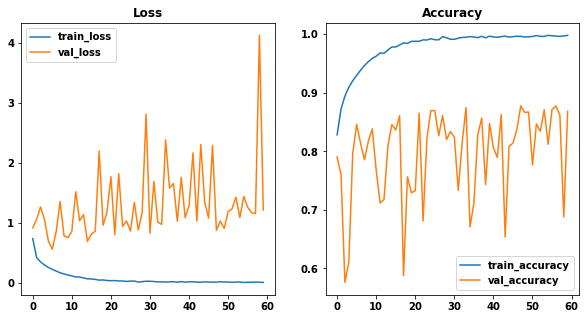

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(filters=96, kernel_size=11, strides=(4, 4), padding='valid', activation='relu',
                        input_shape=(227, 227, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),padding='valid'))

model.add(layers.Conv2D(filters=256, kernel_size=(
        5, 5), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(layers.Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=256, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
              loss= losses.CategoricalCrossentropy(),
              metrics = ['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=60,  # Number of epochs
                    validation_data=val_generator,
                    validation_freq=1,
                    validation_steps=200,  # Number of validation samples to run validation on
                    )

display_model_trainTestGraphs(results)

In [11]:
results.model.save(tf_chkpt_path+'Model_1_plusMaxPooling')

INFO:tensorflow:Assets written to: tf_AlexNet_checkpoints/Model_1_plusMaxPooling\assets


INFO:tensorflow:Assets written to: tf_AlexNet_checkpoints/Model_1_plusMaxPooling\assets
